In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

import tf_lab.autopredictors.scripts.virt_scan_data as vscan
from tf_lab.autopredictors.scripts.fsdf_bin_parser import fsdf_bin_parser

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, points_extension, \
                                                 shape_net_core_synth_id_to_category

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch,
    
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion, save_reconstructions, \
                                           save_pc_prediction_stats, \
                                           paper_pc_completion_experiment_id_best_epoch
                                           
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs, copy_folder_structure
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud, Mesh
from geo_tool.solids import mesh_cleaning as cleaning

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [123]:
# Prepare data for Minhyuk's rendering machine.

loss = 'chamfer'
class_type = 'airplane'
class_syn_id = shape_net_category_to_synth_id()[class_type]

incomplete_n_samples = 2048
complete_n_samples = 4096

experiment_id, best_epoch = paper_pc_completion_experiment_id_best_epoch(class_type, loss)


experiment_name = str(experiment_id) + '_' + class_type + '_' + str(incomplete_n_samples) + '_' \
                  + str(complete_n_samples) + 'pts_' + loss


top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/paper_vanilla_vscan/'
ply_files_dir = osp.join(top_data_dir, experiment_name, 'output', 'epoch_' + str(best_epoch), 'test_predictions')
save_dir = osp.join(top_data_dir, 'cherries', 'Minhuyk_renderered')
create_dir(save_dir)
jingwei_cherries_dir = osp.join(top_data_dir, 'cherries', 'Jinwei_cherries')
copy_folder_structure(jingwei_cherries_dir, save_dir)

fgen = files_in_subdirs(jingwei_cherries_dir, '.prediction.png')

for c, f in enumerate(fgen):
    d = osp.dirname(f)
    experiment_id, class_type, loss =  d.split('/')[-2].split('_')
    new_location = d.replace('Jinwei_cherries', 'Minhuyk_renderered')    
    new_location = create_dir(osp.join(new_location, str(c)))
    rank, syn_id, model_name, scan_id, _, _ = osp.basename(f).split('.')
    class_syn_id = shape_net_category_to_synth_id()[class_type]
    experiment_id_2, best_epoch = paper_pc_completion_experiment_id_best_epoch(class_type, loss)
    assert(experiment_id_2 == int(experiment_id))
    experiment_name = str(experiment_id) + '_' + class_type + '_' + str(incomplete_n_samples) + '_' \
                    + str(complete_n_samples) + 'pts_' + loss
        
    
    
    ply_files_dir = osp.join(top_data_dir, experiment_name, 'output', 'epoch_' + str(best_epoch), 'test_predictions')        

    f1 = osp.join(ply_files_dir, syn_id+'.'+model_name +'.'+scan_id + 'prediction.ply')
    f2 = osp.join(ply_files_dir, syn_id+'.'+model_name +'.'+scan_id + '_prediction.ply')
    f3 = osp.join(ply_files_dir, model_name +'.'+scan_id + '_prediction.ply')

    if osp.exists(f1):
        pred = Point_Cloud(ply_file=f1)        
        feed = Point_Cloud(ply_file=f1.replace('prediction.ply', 'feed.ply'))
        gt = Point_Cloud(ply_file=f1.replace('feed.ply', 'gt.ply'))
    elif osp.exists(f2):
        pred = Point_Cloud(ply_file=f2)        
        feed = Point_Cloud(ply_file=f2.replace('prediction.ply', 'feed.ply'))
        gt = Point_Cloud(ply_file=f2.replace('feed.ply', 'gt.ply'))
    elif osp.exists(f3):
        pred = Point_Cloud(ply_file=f3)            
        feed = Point_Cloud(ply_file=f3.replace('prediction.ply', 'feed.ply'))
        gt = Point_Cloud(ply_file=f3.replace('feed.ply', 'gt.ply'))
    else:
        assert(False)
    
                        
    tag = model_name + "." +scan_id
    save_prediction_f = osp.join(new_location,  tag + '_prediction')
    pred.save_as_ply(save_prediction_f)
    pred = pred.points

    save_feed_f = osp.join(new_location, tag + '_feed')
    feed.save_as_ply(save_feed_f)
    feed = feed.points

    save_gt_f = osp.join(new_location, tag + '_gt')
    gt.save_as_ply(save_gt_f)
    gt = gt.points


    ac_meas, ac_col = accuracy_of_completion(pred, gt, thres=0.02, ret_dists=True)
    cov_meas, cov_col = coverage_of_completion(gt, pred, thres=0.02, ret_dists=True)

    np.savetxt(osp.join(new_location, tag + '_prediction.csv'), ac_col)
    np.savetxt(osp.join(new_location, tag + '_gt.csv'), cov_col)


In [65]:
# SAMPLE-STORE incomplete from Mattias (small test data).
incomplete_n_samples = 2048

load_original_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_dim32_sdf_pc/'
top_save_dir = create_dir('/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/test_feed_data/small_2048_subsampled')
test_white_list = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/train_test_models/test_models_small.txt'

with open(test_white_list, 'r') as fin:     
    for line in fin:
        syn_id, model_name = line.rstrip().split()
        save_dir = create_dir(osp.join(top_save_dir, syn_id))
        for scan_id in range(6):
            tag = model_name + '__' + str(scan_id) + '__'
            pc_f = osp.join(load_original_dir, syn_id, tag  + '.ply')
            pc = Point_Cloud(ply_file=pc_f)
            if pc.num_points > incomplete_n_samples:
                pc, _ = pc.sample(incomplete_n_samples)
            
            pc.save_as_ply(osp.join(save_dir, tag))        

print len([f for f in files_in_subdirs(top_save_dir, '.ply')])

In [3]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/paper_vanilla_vscan/'
save_dir = osp.join(top_data_dir, 'cherries', 'Minhuyk_renderered')
create_dir(save_dir)
jingwei_cherries_dir = osp.join(top_data_dir, 'cherries', 'Jinwei_cherries')
copy_folder_structure(jingwei_cherries_dir, save_dir)

fgen = files_in_subdirs(jingwei_cherries_dir, '.prediction.png')






In [5]:
    incomplete_n_samples = 2048
    complete_n_samples = 4096
    f = fgen.next()
    c = 1
    d = osp.dirname(f)
    experiment_id, class_type, loss =  d.split('/')[-2].split('_')
    new_location = d.replace('Jinwei_cherries', 'Minhuyk_renderered')    
    new_location = create_dir(osp.join(new_location, str(c)))
    rank, syn_id, model_name, scan_id, _, _ = osp.basename(f).split('.')
    class_syn_id = shape_net_category_to_synth_id()[class_type]
    experiment_id_2, best_epoch = paper_pc_completion_experiment_id_best_epoch(class_type, loss)
    assert(experiment_id_2 == int(experiment_id))
    experiment_name = str(experiment_id) + '_' + class_type + '_' + str(incomplete_n_samples) + '_' \
                    + str(complete_n_samples) + 'pts_' + loss
        
        
    ply_files_dir = osp.join(top_data_dir, experiment_name, 'output', 'epoch_' + str(best_epoch), 'test_predictions')        

    f1 = osp.join(ply_files_dir, syn_id+'.'+model_name +'.'+scan_id + 'prediction.ply')
    f2 = osp.join(ply_files_dir, syn_id+'.'+model_name +'.'+scan_id + '_prediction.ply')
    f3 = osp.join(ply_files_dir, model_name +'.'+scan_id + '_prediction.ply')

    if osp.exists(f1):
        pred = Point_Cloud(ply_file=f1)        
        feed = Point_Cloud(ply_file=f1.replace('prediction.ply', 'feed.ply'))
        gt = Point_Cloud(ply_file=f1.replace('feed.ply', 'gt.ply'))
    elif osp.exists(f2):
        pred = Point_Cloud(ply_file=f2)        
        feed = Point_Cloud(ply_file=f2.replace('prediction.ply', 'feed.ply'))
        gt = Point_Cloud(ply_file=f2.replace('feed.ply', 'gt.ply'))
    elif osp.exists(f3):
        pred = Point_Cloud(ply_file=f3)            
        feed = Point_Cloud(ply_file=f3.replace('prediction.ply', 'feed.ply'))
        gt = Point_Cloud(ply_file=f3.replace('feed.ply', 'gt.ply'))
    else:
        assert(False)
        
    
                        
#     tag = model_name + "." +scan_id
#     save_prediction_f = osp.join(new_location,  tag + '_prediction')
#     pred.save_as_ply(save_prediction_f)
#     pred = pred.points

#     save_feed_f = osp.join(new_location, tag + '_feed')
#     feed.save_as_ply(save_feed_f)
#     feed = feed.points

#     save_gt_f = osp.join(new_location, tag + '_gt')
#     gt.save_as_ply(save_gt_f)
#     gt = gt.points


    ac_meas, ac_col = accuracy_of_completion(pred.points, gt.points, thres=0.00002, ret_dists=True)
    cov_meas, cov_col = coverage_of_completion(gt.points, pred.points, thres=0.000002, ret_dists=True)

#     np.savetxt(osp.join(new_location, tag + '_prediction.csv'), ac_col)
#     np.savetxt(osp.join(new_location, tag + '_gt.csv'), cov_col)

In [58]:
class_type = 'car'
loss = 'emd'

incomplete_n_samples = 2048
complete_n_samples = 4096
class_syn_id = shape_net_category_to_synth_id()[class_type]
experiment_id, best_epoch = paper_pc_completion_experiment_id_best_epoch(class_type, loss)
topd = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/paper_vanilla_vscan/'+ str(experiment_id) + '_' + class_type + '_' + '2048_4096pts_' + loss + '/output/'

print topd
topd1 = osp.join(topd, 'epoch_' + str(best_epoch)+ '/500_best_test_predictions')

all_pred = [f for f in files_in_subdirs(topd1, '.prediction.png')]


/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/paper_vanilla_vscan/3_car_2048_4096pts_emd/output/


In [13]:
%matplotlib inline

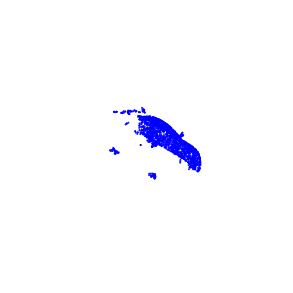

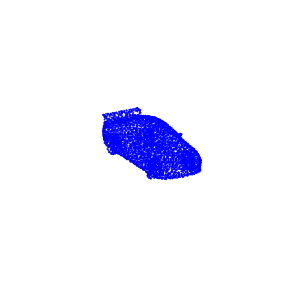

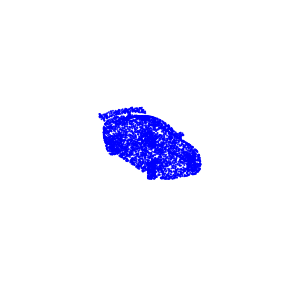

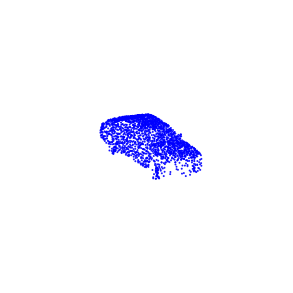

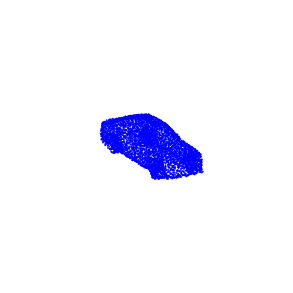

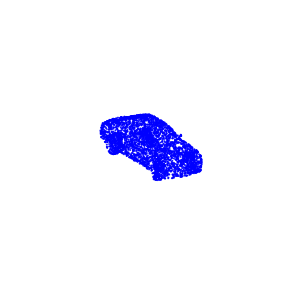

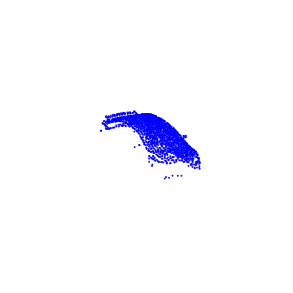

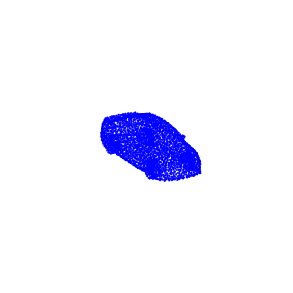

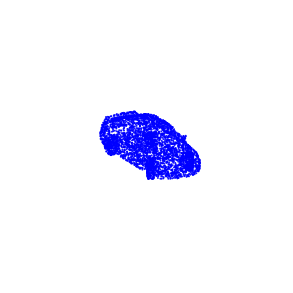

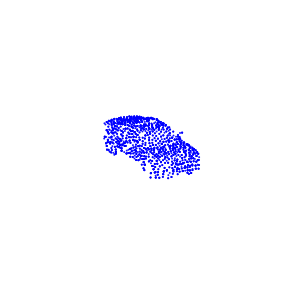

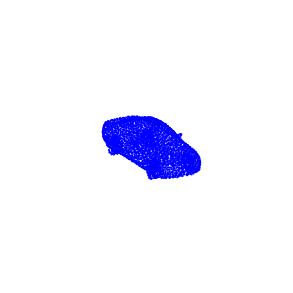

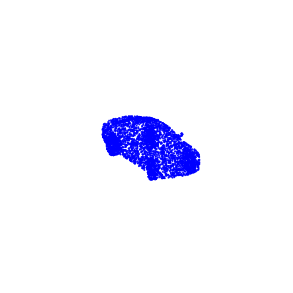

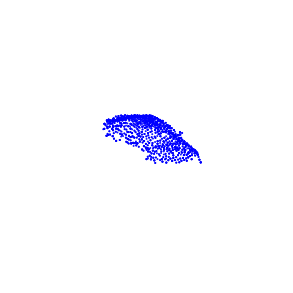

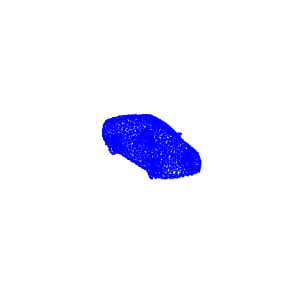

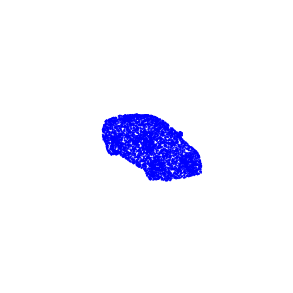

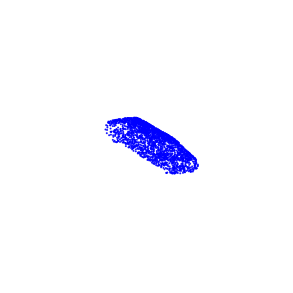

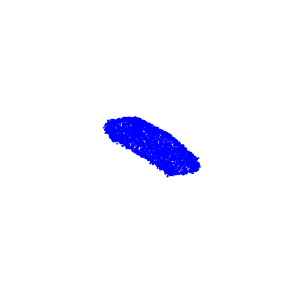

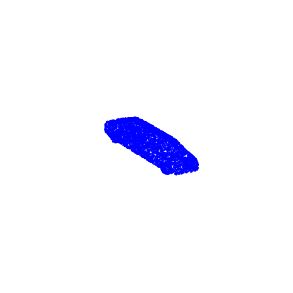

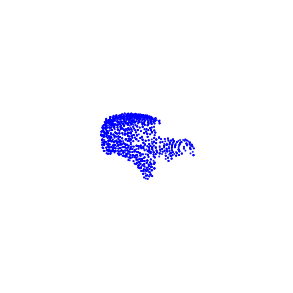

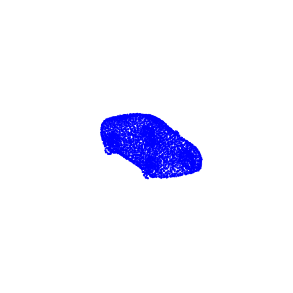

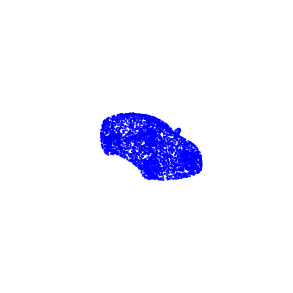

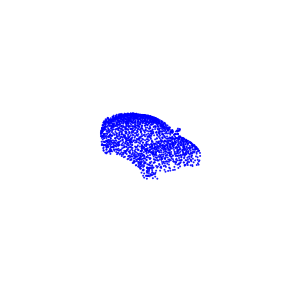

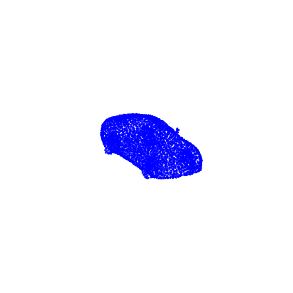

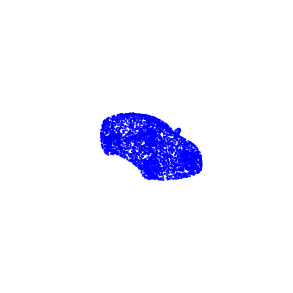

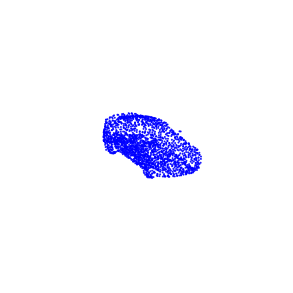

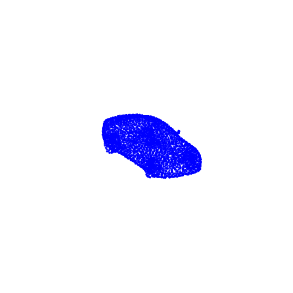

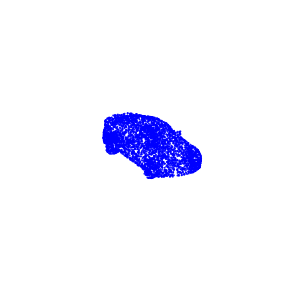

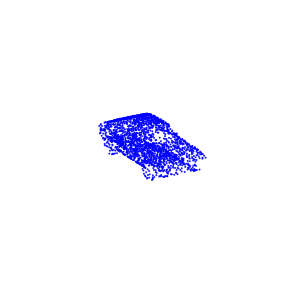

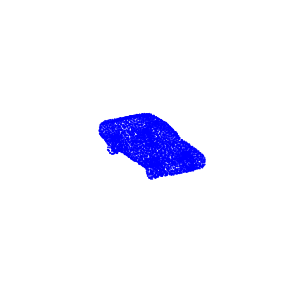

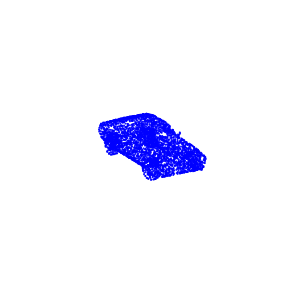

KeyboardInterrupt: 

In [59]:
#  class_syn_id + '.' +# 
#  class_syn_id + '.' 
for pc in all_pred:
    rank, syn_id, model_name, scan_id, _, _ = osp.basename(pc).split('.')
    yo = osp.join(topd, 'epoch_' + str(best_epoch), 'test_predictions')
    pred_file = osp.join(yo, model_name + '.' + scan_id + '_prediction.ply')
    feed_file = osp.join(yo, model_name + '.' + scan_id + '_feed.ply')
    gt_file   = osp.join(yo,model_name + '.' + scan_id + '_gt.ply')
    pred_pc = Point_Cloud(ply_file=pred_file)
    feed_pc = Point_Cloud(ply_file=feed_file)
    gt_pc   = Point_Cloud(ply_file=gt_file)
            
        
    
    plot_3d_point_cloud_paper(feed_pc, show=True, in_u_sphere=True, axis=None, elev=20, azim=330,\
                              marker='.', s=4, alpha=.8);
        
        
    plot_3d_point_cloud_paper(pred_pc, show=True, in_u_sphere=True, axis=None, elev=20, azim=330,\
                              marker='.', s=4, alpha=.8);
        
    plot_3d_point_cloud_paper(gt_pc,   show=True, in_u_sphere=True, axis=None, elev=20, azim=330,\
                              marker='.', s=4, alpha=.8);
        
        
        
        
    raw_input()

In [ ]:


def plot_3d_point_cloud_paper(pc_cloud, show=True, in_u_sphere=False, axis=None, elev=20, azim=330,
                              marker='.', s=40, alpha=.8, *args, **kwargs):
    if axis is None:
        fig = plt.figure(figsize=(2,2))
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = axis
        fig = axis

    x = pc_cloud.points[:, 0]
    y = pc_cloud.points[:, 1]
    z = pc_cloud.points[:, 2]

    ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, color=['blue','blue','blue'])
    ax.view_init(elev=elev, azim=azim)
    plt.axis('off')

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)

    if show:
        plt.show()
    return fig